# Introduction 

This notebook contains the code to get the respiration of interacting pairs of microbes. This is done in lieu of an analytical solution of the paired interaction model. The growth of a single microbe can be represented as:

\begin{align}
    \frac{1}{C}\frac{dC}{dt} = \mu - R
\end{align}

Where $C$ is the carbon biomass, $\mu$ and $R$ are the effective carbon uptake (including the inefficiency) and maintenance respiration. Species interactions in this model may be included via alteration of the uptake rate $\mu$ as interactions either alter the maximal uptake rate or the efficency of allocation to biomass. The model for the growth of a pair of species is then:

\begin{align}
    \frac{1}{C_1}\frac{dC_1}{dt} &= \mu_1 + C_2 \alpha_{12} - R_{m_1} \\
    \frac{1}{C_2}\frac{dC_2}{dt} &= \mu_2 + C_1 \alpha_{21} - R_{m_2}
\end{align}

where the new term $\alpha_{ij}$ is the effect of species $j$ on the uptake rate of species $i$. To get the temperature dependence of these parameters we need to substitute the Arrhenius equation for the uptake and respiration terms:
\begin{align}
    B(T) = B_0 e^{-E (T_r - T_{ra})}
\end{align}

# Parameterisation

This numerical approach requires parameterisation of the model above. The epsilon parameters represent the inefficency of the conversion of carbon taken up by the cell into biomass and have been estimated to be somewhere between 12 and 29% (Gommers et al. 1988). For uptake and respiration I use temperature sensitvites of $0.65$ and $0.98$ from Tom's work and normalisation constants where $\mu_0$ is around twice the value of $R_0$. 

## Interactions

I will vary the interaction parameters such that they remain equal (i.e $a_{12} = a_{21}$).

# Simulation

In [1]:
#load packages
using DifferentialEquations, Plots

In [215]:
#defining constant
const k = 8.617e-5

#defining parameters
struct Boltz
    B_0::Float64
    E::Float64
end

struct Params
    ep_1::Float64; ep_2::Float64
    u_1::Boltz;  u_2::Boltz
    a_12::Boltz; a_21::Boltz
    R_1::Boltz; R_2::Boltz
    T::Float64
end

In [218]:
#Boltzmann helper function
function boltz(b::Boltz,T::Float64)
    return(b.B_0 * exp(- b.E/k * ((1/T) - (1/295.0)) ))
end

#Defining problem
function paired_growth(dC,C,p,t)
    dC[1] = C[1] * ( (p.ep_1 * (boltz(p.u_1,p.T) + boltz(p.a_12,p.T))) - boltz(p.R_1,p.T) )
    dC[2] = C[2] * ( (p.ep_2 * (boltz(p.u_2,p.T) + boltz(p.a_21,p.T))) - boltz(p.R_2,p.T) )
end

paired_growth (generic function with 1 method)

In [219]:
boltz_average(Boltz(1,0.65),Boltz(1,0.65),Boltz(1,0.65))

(Boltz(1.0, 0.65),)

In [253]:
#random parameter generator
function simulate(alpha::Float64)
    u_r_ratio = (rand(2)/10)+0.45
    sp_1_2_ratio = (rand()/10)+0.95
    E_u = (rand(2)/10) + 0.93
    E_r = (rand(2)/10) + 0.6

    u_1_0 = 1
    u_2_0 = 1 * sp_1_2_ratio
    
    R_1_0 = u_r_ratio[1] * u_1_0
    R_2_0 = u_r_ratio[2] * u_2_0
    #define boltzmans
    u1 = Boltz(u_1_0,E_u[1])
    u2 = Boltz(u_2_0,E_u[2])
    r1 = Boltz(R_1_0,E_r[1])
    r2 = Boltz(R_2_0,E_r[2])
    a12 = Boltz(alpha,0.0)
    a21 = Boltz(alpha,0.0)
    C0 = [1.0,1.0]
    tspan = (0.0,2.0)
    Temp = linspace(275.0,315.0,100)
    
    results = Vector(100)
    for T in 1:100
        T_loop = Temp[T]
        p = Params(0.3,0.3,u1,u2,a12,a21,r1,r2,T_loop)
        prob = ODEProblem(paired_growth,C0,tspan,p)
        sol = solve(prob)
        a = sum(sol(1) .* [boltz(r1,T_loop),boltz(r2,T_loop)])
        results[T] = a
    end
    return(results)
    
end

simulate (generic function with 2 methods)

In [302]:
r = hcat([mean(hcat([simulate(a) for i in 1:100]...),2) for a in linspace(-1,1,20)]...)

100×20 Array{Float64,2}:
  0.109375   0.111909   0.116162  …   0.186706   0.19341    0.195877
  0.113607   0.116248   0.120645      0.193947   0.200918   0.203523
  0.117984   0.120735   0.125281      0.201435   0.208683   0.211433
  0.122508   0.125375   0.130073      0.209177   0.216711   0.219612
  0.127184   0.130171   0.135026      0.21718    0.22501    0.228071
  0.132017   0.135128   0.140144  …   0.225451   0.233587   0.236815
  0.137011   0.140251   0.145432      0.233998   0.242451   0.245853
  0.14217    0.145543   0.150894      0.242828   0.251609   0.255193
  0.147499   0.15101    0.156536      0.25195    0.261069   0.264844
  0.153002   0.156657   0.162362      0.26137    0.270839   0.274814
  0.158684   0.162488   0.168377  …   0.271098   0.280928   0.285113
  0.16455    0.168509   0.174587      0.281141   0.291344   0.295749
  0.170605   0.174724   0.180997      0.291509   0.302097   0.30673 
  ⋮                               ⋱                                 
  3.52297

In [303]:
using DataFrames

r = DataFrame(r)
r = stack(r)

,variable,value
1,x1,0.109375
2,x1,0.113607
3,x1,0.117984
4,x1,0.122508
5,x1,0.127184
6,x1,0.132017
7,x1,0.137011
8,x1,0.14217
9,x1,0.147499
10,x1,0.153002


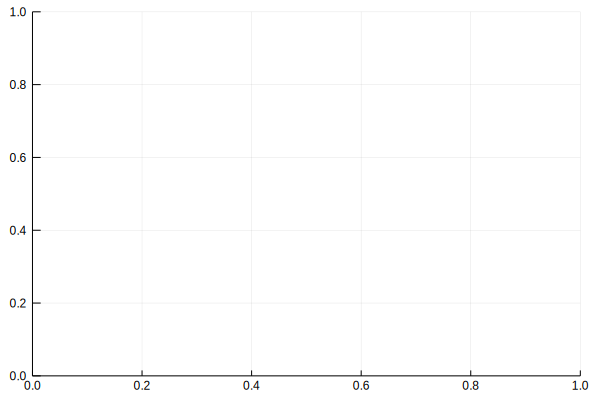

In [308]:
using StatPlots

@df r plot()

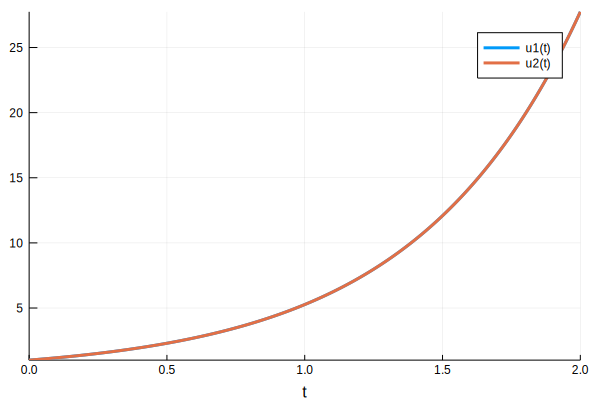

In [112]:
#run simulations (identical species)
u1 = Boltz(2.0,0.65)
u2 = Boltz(2.0,0.65)
a12 = Boltz(0.5,0.0)
a21 = Boltz(0.5,0.0)
r1 = Boltz(1.0,0.98)
r2 = Boltz(1.0,0.98)

C0 = [1.0,1.0]
tspan = (0.0,2.0)
p = Params(1.0,1.0,u1,u2,a12,a21,r1,r2,300.)

prob = ODEProblem(paired_growth,C0,tspan,p)
sol = solve(prob)
plot(sol)

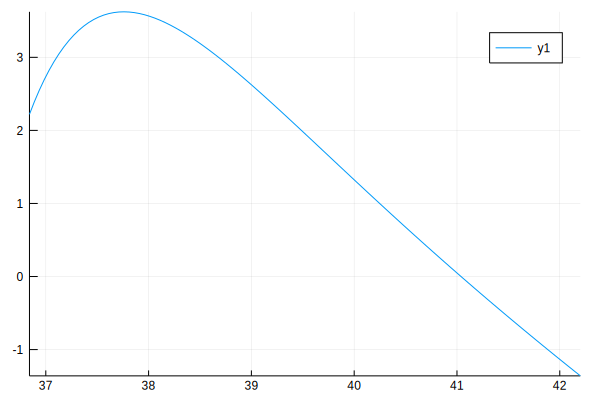

In [113]:
# defining functions 
#simulate function
function sim(T::Float64)
    C0 = [1.0,1.0]
    tspan = (0.0,1.0)
    p = Params(1.0,1.0,u1,u2,a12,a21,r1,r2,T)
    prob = ODEProblem(paired_growth,C0,tspan,p)
    sol = solve(prob)
    return( sum(sol(1)) * boltz(r1,T))
end

result = [sim(t) for t in linspace(275,315,100)]

plot(1/(k*linspace(275,315,100)),log.(result))


In [224]:
## Methods 

sol(1) .* [2,2] 

2-element Array{Float64,1}:
 10.5341
 10.5341